## Preprocessing

In [1]:
import pandas as pd
import re

In [5]:
data = pd.read_csv('test_selenium.csv')
summaries = data['Summary']
analyses = data['Analysis']
titles = data['Title']

corpus = [f"{title} {summary} {analysis}" for title, summary, analysis in zip(titles, summaries, analyses)]

def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub(r'\d+', '', text)
    text = text.strip()
    return text

preprocessed_corpus = [preprocess_text(text) for text in corpus]

tokenized_corpus = [text.split() for text in preprocessed_corpus]

## Training Word Embedding Model To Obtain Embeddings

In [8]:
from gensim.models import Word2Vec

Word2Vec_model_sg = Word2Vec(tokenized_corpus, vector_size=100, window=5, min_count=1, workers=4, sg=1)

Word2Vec_model_sg.save('Word2Vec_model_sg')

In [10]:
test_vector = Word2Vec_model_sg.wv['darkness']
print(test_vector)

[-0.18757609 -0.02523065  0.10822345  0.25279427  0.09404436 -0.14556998
  0.31167802  0.56639236 -0.07748945 -0.11939991 -0.2481058  -0.37848467
 -0.0188977  -0.1670922  -0.10497189 -0.08356968 -0.0615345   0.10890697
 -0.10079912 -0.40617284 -0.00819069 -0.1524098   0.16265742 -0.03898332
 -0.06940196  0.04204768 -0.03904338 -0.06583715 -0.15557028  0.20045884
  0.3325572   0.00232724  0.14604664 -0.25277588 -0.20083642  0.21060328
  0.01625244 -0.34341818 -0.21040498 -0.30221328  0.05520817 -0.08441182
  0.0313545   0.01122725  0.27458957 -0.2581353  -0.3079668  -0.02439034
 -0.22528283  0.05035021 -0.07226291 -0.00409833 -0.03894206  0.06516527
  0.09041492 -0.08996686  0.08819439 -0.06942315  0.07562473  0.10474674
  0.00300599 -0.16347326  0.36412808  0.02851762 -0.01989603  0.17973474
  0.06861334  0.25913286 -0.15470749  0.06786061 -0.00504779  0.20889491
  0.2030788  -0.25446317  0.15321966  0.13806863  0.31823     0.15149638
 -0.43128183 -0.07699223 -0.12870276 -0.00841347  0

In [18]:
similar_words = Word2Vec_model_sg.wv.most_similar('friend')
print(similar_words)

[('brother', 0.8718932867050171), ('wife', 0.8443353176116943), ('servant', 0.8382858633995056), ('sister', 0.8214103579521179), ('aunt', 0.8185446858406067), ('girlfriend', 0.8092584609985352), ('acquaintance', 0.802879810333252), ('grandfather', 0.8003736138343811), ('roommate', 0.7951571345329285), ('companion', 0.7915104627609253)]


In [25]:
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

def sentence_vector(sentence, model):
    words = sentence.split()
    valid_vectors = [model.wv[word] for word in words if word in model.wv]
    return np.mean(valid_vectors, axis=0) if valid_vectors else np.zeros(model.vector_size)

user_input = "I am feeling very sad and lonely. I don't have any friends to talk to."
preprocessed_input = preprocess_text(user_input)
input_vector = sentence_vector(preprocessed_input, Word2Vec_model_sg)

corpus_vectors = [sentence_vector(entry, Word2Vec_model_sg) for entry in preprocessed_corpus]
similarities = cosine_similarity([input_vector], corpus_vectors)

most_similar_index = np.argmax(similarities)
print(f"Most similar entry: {corpus[most_similar_index]}")


Most similar entry: the-killers George brings Max and Al their meals, but they can’t remember who ordered what. As they eat, they catch George looking at them. Al suggests that “maybe the boy meant it for a joke,” and George laughs. Max tells him not to laugh and George says alright. To Al, Max says “he thinks it’s all right,” and Al replies, “Oh, he’s a thinker.” Max and Al want to seem like they are in control of the situation and know what they are doing, but their confusion over who ordered what reveals how easy it is to fluster them (and shows them to be either a little stupid or unobservant—an inauspicious beginning for criminals). Frustrated by this confusion, they again emasculate George to put him in his place as their inferior.


# Fine-Tuning Pretrained Models

### T5-Small

In [12]:
import pandas as pd

data = pd.read_csv('test_selenium.csv')
data['Input'] = data['Summary']
data['Output'] = data['Analysis']

data[['Input', 'Output']].to_csv('fine_tuning_data.csv', index=False)

In [13]:
from datasets import load_dataset

dataset = load_dataset('csv', data_files={"train": 'fine_tuning_data.csv'})

split = dataset['train'].train_test_split(test_size=0.1)
train_dataset = split['train']
test_dataset = split['test']

split = train_dataset.train_test_split(test_size=0.1)
train_dataset = split['train']
val_dataset = split['test']

print(f"Train size: {len(train_dataset)}")
print(f"Validation size: {len(val_dataset)}")
print(f"Test size: {len(test_dataset)}")


Generating train split: 5095 examples [00:00, 73840.83 examples/s]

Train size: 4126
Validation size: 459
Test size: 510


In [14]:
from transformers import T5Tokenizer, T5ForConditionalGeneration

model_name = 't5-small'
tokenizer = T5Tokenizer.from_pretrained(model_name)
model = T5ForConditionalGeneration.from_pretrained(model_name)

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [15]:
def preprocess_function(examples):
    # Check for empty inputs or outputs
    if "Input" not in examples or "Output" not in examples:
        raise ValueError("Input or output column missing in dataset.")
    
    # Ensure input and output are non-empty strings
    inputs = examples["Input"]  # Replace with your dataset's input column
    targets = examples["Output"]  # Replace with your dataset's output column
    
    if not inputs or not targets:
        raise ValueError("Empty input or output found in the dataset.")

    # Tokenize inputs and outputs
    model_inputs = tokenizer(
        inputs,
        max_length=256,
        truncation=True,
        padding="max_length"
    )
    labels = tokenizer(
        targets,
        max_length=256,
        truncation=True,
        padding="max_length"
    )

    model_inputs["labels"] = labels["input_ids"]
    return model_inputs

# Reapply preprocessing
tokenized_train = train_dataset.map(preprocess_function, batched=True)
tokenized_val = val_dataset.map(preprocess_function, batched=True)
tokenized_test = test_dataset.map(preprocess_function, batched=True)


Map: 100%|██████████| 510/510 [00:00<00:00, 1408.85 examples/s]


In [16]:
from transformers import DataCollatorForSeq2Seq

data_collator = DataCollatorForSeq2Seq(tokenizer=tokenizer, model=model_name)


In [17]:
import os
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"

from torch import cuda
print(cuda.is_available())  # Should return True if GPU is available

cuda.empty_cache()



True


In [18]:
from datasets import load_metric

metric = load_metric("rouge")  # Replace with the appropriate metric for your task

def compute_metrics(eval_preds):
    predictions, labels = eval_preds
    decoded_preds = tokenizer.batch_decode(predictions, skip_special_tokens=True)
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)

    # Rouge expects a list of strings
    result = metric.compute(predictions=decoded_preds, references=decoded_labels)
    return {key: value.mid.fmeasure for key, value in result.items()}

c:\Users\RoG\anaconda3\envs\licenta\lib\site-packages\datasets\load.py:759: FutureWarning: The repository for rouge contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.19.0/metrics/rouge/rouge.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(


In [32]:
from transformers import Seq2SeqTrainer, Seq2SeqTrainingArguments
import torch
import os

# Clear GPU cache and set memory configuration
torch.cuda.empty_cache()
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"

training_args = Seq2SeqTrainingArguments(
    output_dir="./fine_tuned_t5",
    evaluation_strategy="epoch",         # Evaluate after each epoch
    save_strategy="epoch",               # Save model after each epoch
    learning_rate=3e-5,                  # Lower learning rate for better fine-tuning
    per_device_train_batch_size=8,       # Increase batch size if memory allows
    per_device_eval_batch_size=8,        # Match eval batch size to train batch size
    gradient_accumulation_steps=2,       # Adjust accumulation to simulate a larger batch size
    num_train_epochs=5,                  # Increase epochs to ensure better learning
    weight_decay=0.01,                   # Retain weight decay for regularization
    save_total_limit=3,                  # Save more models to track progress
    logging_steps=100,                   # Log more frequently for monitoring
    fp16=True,                           # Enable mixed precision for faster training
    predict_with_generate=True,          # Enable text generation during evaluation
    load_best_model_at_end=True,         # Load the best model based on `metric_for_best_model`
    metric_for_best_model="eval_loss",   # Monitor evaluation loss for the best model
    greater_is_better=False,             # Ensure lower eval loss is considered better
    generation_max_length=50,            # Limit generated sequences for evaluation
    generation_num_beams=5               # Use beam search to improve text quality
)


# Use Seq2SeqTrainer
trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_val,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics  # Custom evaluation metrics
)

# Start training
trainer.train()

# Save the fine-tuned model and tokenizer
model.save_pretrained('fine_tuned_t5')
tokenizer.save_pretrained('fine_tuned_t5_tokenizer')


  8%|▊         | 100/1290 [00:25<05:10,  3.83it/s]

{'loss': 1.1581, 'grad_norm': 0.3415832221508026, 'learning_rate': 2.7674418604651162e-05, 'epoch': 0.39}


 16%|█▌        | 200/1290 [00:51<04:41,  3.87it/s]

{'loss': 1.1516, 'grad_norm': 0.33523938059806824, 'learning_rate': 2.5348837209302324e-05, 'epoch': 0.78}


 20%|██        | 258/1290 [02:26<04:23,  3.92it/s]

{'eval_loss': 1.1029659509658813, 'eval_rouge1': 0.22700377966625454, 'eval_rouge2': 0.038164259311995546, 'eval_rougeL': 0.1573013775566554, 'eval_rougeLsum': 0.15728417719725557, 'eval_runtime': 79.6243, 'eval_samples_per_second': 5.765, 'eval_steps_per_second': 0.728, 'epoch': 1.0}


 23%|██▎       | 300/1290 [02:38<04:14,  3.89it/s]  

{'loss': 1.1731, 'grad_norm': 0.4614662230014801, 'learning_rate': 2.302325581395349e-05, 'epoch': 1.16}


 31%|███       | 400/1290 [03:04<03:48,  3.90it/s]

{'loss': 1.1377, 'grad_norm': 0.3278246521949768, 'learning_rate': 2.069767441860465e-05, 'epoch': 1.55}


 39%|███▉      | 500/1290 [03:30<03:27,  3.80it/s]

{'loss': 1.1569, 'grad_norm': 0.3780752420425415, 'learning_rate': 1.8372093023255815e-05, 'epoch': 1.94}


 40%|████      | 516/1290 [04:54<03:13,  4.00it/s]

{'eval_loss': 1.1011240482330322, 'eval_rouge1': 0.2275511181561969, 'eval_rouge2': 0.03803725032615746, 'eval_rougeL': 0.15706523098023903, 'eval_rougeLsum': 0.15708350142359637, 'eval_runtime': 79.5357, 'eval_samples_per_second': 5.771, 'eval_steps_per_second': 0.729, 'epoch': 2.0}


 47%|████▋     | 600/1290 [05:17<03:01,  3.81it/s]  

{'loss': 1.1412, 'grad_norm': 0.47076189517974854, 'learning_rate': 1.6046511627906977e-05, 'epoch': 2.33}


 54%|█████▍    | 700/1290 [05:43<02:32,  3.87it/s]

{'loss': 1.1677, 'grad_norm': 0.3033689558506012, 'learning_rate': 1.3720930232558139e-05, 'epoch': 2.71}


 60%|██████    | 774/1290 [07:22<02:08,  4.01it/s]

{'eval_loss': 1.0996617078781128, 'eval_rouge1': 0.2258617359052731, 'eval_rouge2': 0.03663470168663069, 'eval_rougeL': 0.1577939218582619, 'eval_rougeLsum': 0.15774778563332564, 'eval_runtime': 79.2244, 'eval_samples_per_second': 5.794, 'eval_steps_per_second': 0.732, 'epoch': 3.0}


 62%|██████▏   | 800/1290 [07:30<02:08,  3.81it/s]  

{'loss': 1.1374, 'grad_norm': 0.3430788815021515, 'learning_rate': 1.1395348837209304e-05, 'epoch': 3.1}


 70%|██████▉   | 900/1290 [07:56<01:42,  3.80it/s]

{'loss': 1.1338, 'grad_norm': 0.3221055269241333, 'learning_rate': 9.069767441860465e-06, 'epoch': 3.49}


 78%|███████▊  | 1000/1290 [08:22<01:14,  3.88it/s]

{'loss': 1.1626, 'grad_norm': 0.3305850327014923, 'learning_rate': 6.744186046511628e-06, 'epoch': 3.88}


 80%|████████  | 1032/1290 [09:50<01:05,  3.93it/s]

{'eval_loss': 1.0990241765975952, 'eval_rouge1': 0.22739687748533494, 'eval_rouge2': 0.037879815796081004, 'eval_rougeL': 0.15749871318715244, 'eval_rougeLsum': 0.1575788237634107, 'eval_runtime': 79.9954, 'eval_samples_per_second': 5.738, 'eval_steps_per_second': 0.725, 'epoch': 4.0}


 85%|████████▌ | 1100/1290 [10:09<00:48,  3.90it/s]  

{'loss': 1.1513, 'grad_norm': 0.3287399411201477, 'learning_rate': 4.418604651162791e-06, 'epoch': 4.26}


 93%|█████████▎| 1200/1290 [10:35<00:23,  3.88it/s]

{'loss': 1.1353, 'grad_norm': 0.258544921875, 'learning_rate': 2.0930232558139536e-06, 'epoch': 4.65}


100%|██████████| 1290/1290 [12:12<00:00,  4.03it/s]

{'eval_loss': 1.0988032817840576, 'eval_rouge1': 0.22696615737281944, 'eval_rouge2': 0.03729638835198566, 'eval_rougeL': 0.15664572417852665, 'eval_rougeLsum': 0.15668347390048837, 'eval_runtime': 73.338, 'eval_samples_per_second': 6.259, 'eval_steps_per_second': 0.791, 'epoch': 5.0}


There were missing keys in the checkpoint model loaded: ['encoder.embed_tokens.weight', 'decoder.embed_tokens.weight', 'lm_head.weight'].
100%|██████████| 1290/1290 [12:14<00:00,  1.76it/s]


{'train_runtime': 734.1109, 'train_samples_per_second': 28.102, 'train_steps_per_second': 1.757, 'train_loss': 1.1504131110139595, 'epoch': 5.0}


('fine_tuned_t5_tokenizer\\tokenizer_config.json',
 'fine_tuned_t5_tokenizer\\special_tokens_map.json',
 'fine_tuned_t5_tokenizer\\spiece.model',
 'fine_tuned_t5_tokenizer\\added_tokens.json')

In [2]:
from transformers import T5Tokenizer, T5ForConditionalGeneration

model = T5ForConditionalGeneration.from_pretrained('fine_tuned_t5')
tokenizer = T5Tokenizer.from_pretrained('fine_tuned_t5_tokenizer')

c:\Users\RoG\anaconda3\envs\licenta\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [33]:




# Evaluate the model
results = trainer.evaluate()
print("Evaluation Results:", results)


100%|██████████| 58/58 [01:17<00:00,  1.33s/it]

Evaluation Results: {'eval_loss': 1.0988032817840576, 'eval_rouge1': 0.22696615737281944, 'eval_rouge2': 0.03729638835198566, 'eval_rougeL': 0.15664572417852665, 'eval_rougeLsum': 0.15668347390048837, 'eval_runtime': 78.7555, 'eval_samples_per_second': 5.828, 'eval_steps_per_second': 0.736, 'epoch': 5.0}


In [34]:
from datasets import load_metric

# Load ROUGE metric
rouge = load_metric("rouge")

# Generate predictions on the test set
predictions = trainer.predict(tokenized_test)
decoded_preds = tokenizer.batch_decode(predictions.predictions, skip_special_tokens=True)
decoded_labels = tokenizer.batch_decode(predictions.label_ids, skip_special_tokens=True)

# Compute ROUGE scores
rouge_result = rouge.compute(predictions=decoded_preds, references=decoded_labels)
print("ROUGE Scores:", rouge_result)


c:\Users\RoG\anaconda3\envs\licenta\lib\site-packages\datasets\load.py:759: FutureWarning: The repository for rouge contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.19.0/metrics/rouge/rouge.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(
100%|██████████| 64/64 [01:26<00:00,  1.35s/it]


ROUGE Scores: {'rouge1': AggregateScore(low=Score(precision=0.33490390490526056, recall=0.17585545015694035, fmeasure=0.22227520474270832), mid=Score(precision=0.3456705877825293, recall=0.18182642521811035, fmeasure=0.22838538736343567), high=Score(precision=0.35691200460215605, recall=0.18789847350357655, fmeasure=0.2343835681186756)), 'rouge2': AggregateScore(low=Score(precision=0.05973564524231359, recall=0.030422373890142934, fmeasure=0.03864302808661215), mid=Score(precision=0.06500702428665237, recall=0.03304585805641032, fmeasure=0.04170054544086488), high=Score(precision=0.07117429085479514, recall=0.035979287572104605, fmeasure=0.04520067528191159)), 'rougeL': AggregateScore(low=Score(precision=0.2347150391897406, recall=0.12352538524628558, fmeasure=0.15561207945120936), mid=Score(precision=0.2422539886059607, recall=0.12787330407500191, fmeasure=0.1602583425936732), high=Score(precision=0.25028880451836044, recall=0.13252656077306516, fmeasure=0.16481078152687148)), 'rougeL

In [35]:
# Load BLEU metric
bleu = load_metric("bleu")

# BLEU requires tokenized predictions and references
tokenized_preds = [pred.split() for pred in decoded_preds]
tokenized_labels = [[ref.split()] for ref in decoded_labels]  # BLEU expects a list of references for each prediction

# Compute BLEU score
bleu_result = bleu.compute(predictions=tokenized_preds, references=tokenized_labels)
print("BLEU Score:", bleu_result)


c:\Users\RoG\anaconda3\envs\licenta\lib\site-packages\datasets\load.py:759: FutureWarning: The repository for bleu contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.19.0/metrics/bleu/bleu.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(


BLEU Score: {'bleu': 0.007736160222513284, 'precisions': [0.2797606767072416, 0.03862875062361913, 0.009244878337401079, 0.0024594573822150486], 'brevity_penalty': 0.34746894643613147, 'length_ratio': 0.4861259695105643, 'translation_length': 14541, 'reference_length': 29912}


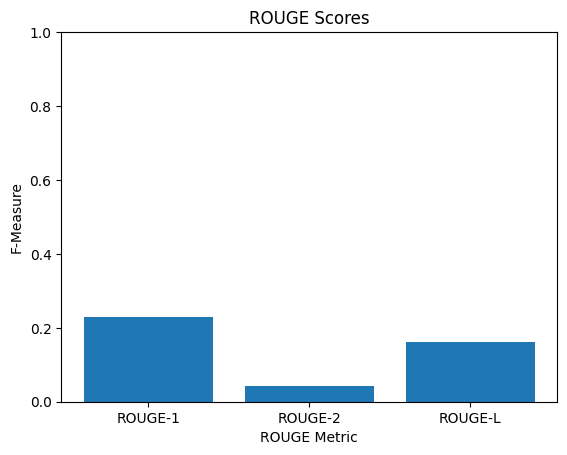

In [36]:
import matplotlib.pyplot as plt

# Extract ROUGE scores (F-measure)
rouge_scores = {
    "ROUGE-1": rouge_result["rouge1"].mid.fmeasure,
    "ROUGE-2": rouge_result["rouge2"].mid.fmeasure,
    "ROUGE-L": rouge_result["rougeL"].mid.fmeasure,
}

# Plot ROUGE scores
plt.bar(rouge_scores.keys(), rouge_scores.values())
plt.title("ROUGE Scores")
plt.ylabel("F-Measure")
plt.xlabel("ROUGE Metric")
plt.ylim(0, 1)
plt.show()


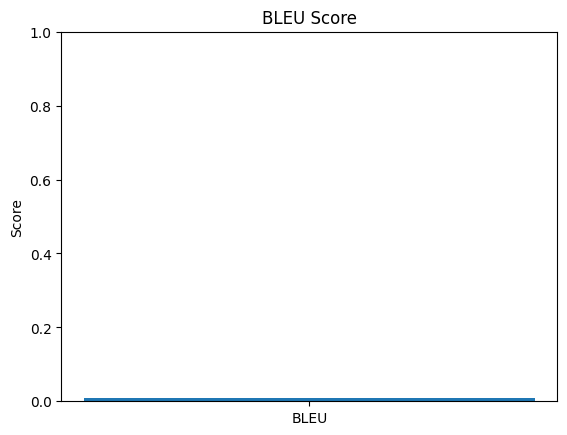

In [37]:
# Plot BLEU score
plt.bar(["BLEU"], [bleu_result["bleu"]])
plt.title("BLEU Score")
plt.ylabel("Score")
plt.ylim(0, 1)
plt.show()


In [42]:
test_text = "Out of this welter of nihilistic reflections, details begin to emerge about Henry’s life in Paris. He lives in the Villa Borghese in the Montparnasse neighborhood with a man named Boris, who’s also a brooding philosophical type. Boris seems to be allowing Henry to stay with him for free, though he employs various excuses to avoid Henry’s repeated requests for breakfast. Henry has no money at all; he has spent his years in Paris as an aspiring writer, but he seems to be letting go of that ambition, though not relinquishing his sense of himself as an “artist” in a vaguer sense."

# Tokenize the input
input_ids = tokenizer(test_text, return_tensors="pt").input_ids.to("cuda")  # Move to GPU if available

# Generate output
outputs = model.generate(
    input_ids,
    max_length=100,         # Allow for longer outputs if needed
    num_beams=10,           # Increase beams for more refined results
    repetition_penalty=2.0, # Penalize repetitive outputs
    length_penalty=2.0,     # Encourage longer outputs
    early_stopping=True
)

# Decode and print the output
decoded_output = tokenizer.decode(outputs[0], skip_special_tokens=True)

print("Generated Output:", decoded_output)

Generated Output: The nihilistic reflections of Henry’s life in Paris begin to emerge. Boris seems to be allowing him to stay with him for free, though he employs various excuses to avoid his repeated requests for breakfast. He has spent his years in Paris as an aspiring writer, but he is not relinquishing his sense of himself as an “artist.”


### T5-Base

In [43]:
import pandas as pd

data = pd.read_csv('test_selenium.csv')
data['Input'] = data['Summary']
data['Output'] = data['Analysis']

data[['Input', 'Output']].to_csv('fine_tuning_data.csv', index=False)

In [44]:
from datasets import load_dataset

dataset = load_dataset('csv', data_files={"train": 'fine_tuning_data.csv'})

split = dataset['train'].train_test_split(test_size=0.1)
train_dataset = split['train']
test_dataset = split['test']

split = train_dataset.train_test_split(test_size=0.1)
train_dataset = split['train']
val_dataset = split['test']

print(f"Train size: {len(train_dataset)}")
print(f"Validation size: {len(val_dataset)}")
print(f"Test size: {len(test_dataset)}")


Generating train split: 5095 examples [00:00, 66169.73 examples/s]

Train size: 4126
Validation size: 459
Test size: 510


In [45]:
from transformers import T5Tokenizer, T5ForConditionalGeneration

model_name = 't5-base'
tokenizer = T5Tokenizer.from_pretrained(model_name)
model = T5ForConditionalGeneration.from_pretrained(model_name)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [46]:
def preprocess_function(examples):
    # Check for empty inputs or outputs
    if "Input" not in examples or "Output" not in examples:
        raise ValueError("Input or output column missing in dataset.")
    
    # Ensure input and output are non-empty strings
    inputs = examples["Input"]  # Replace with your dataset's input column
    targets = examples["Output"]  # Replace with your dataset's output column
    
    if not inputs or not targets:
        raise ValueError("Empty input or output found in the dataset.")

    # Tokenize inputs and outputs
    model_inputs = tokenizer(
        inputs,
        max_length=256,
        truncation=True,
        padding="max_length"
    )
    labels = tokenizer(
        targets,
        max_length=256,
        truncation=True,
        padding="max_length"
    )

    model_inputs["labels"] = labels["input_ids"]
    return model_inputs

# Reapply preprocessing
tokenized_train = train_dataset.map(preprocess_function, batched=True)
tokenized_val = val_dataset.map(preprocess_function, batched=True)
tokenized_test = test_dataset.map(preprocess_function, batched=True)


Map:   0%|          | 0/4126 [00:00<?, ? examples/s]

Map: 100%|██████████| 510/510 [00:00<00:00, 1401.10 examples/s]


In [47]:
from transformers import DataCollatorForSeq2Seq

data_collator = DataCollatorForSeq2Seq(tokenizer=tokenizer, model=model_name)


In [48]:
import os
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"

from torch import cuda
print(cuda.is_available())  # Should return True if GPU is available

cuda.empty_cache()



True


In [49]:
from datasets import load_metric

metric = load_metric("rouge")  # Replace with the appropriate metric for your task

def compute_metrics(eval_preds):
    predictions, labels = eval_preds
    decoded_preds = tokenizer.batch_decode(predictions, skip_special_tokens=True)
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)

    # Rouge expects a list of strings
    result = metric.compute(predictions=decoded_preds, references=decoded_labels)
    return {key: value.mid.fmeasure for key, value in result.items()}

c:\Users\RoG\anaconda3\envs\licenta\lib\site-packages\datasets\load.py:759: FutureWarning: The repository for rouge contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.19.0/metrics/rouge/rouge.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(


In [50]:
from transformers import Seq2SeqTrainer, Seq2SeqTrainingArguments
import torch
import os

# Clear GPU cache and set memory configuration
torch.cuda.empty_cache()
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"

training_args = Seq2SeqTrainingArguments(
    output_dir="./fine_tuned_t5_base",
    evaluation_strategy="epoch",         # Evaluate after each epoch
    save_strategy="epoch",               # Save model after each epoch
    learning_rate=3e-5,                  # Lower learning rate for better fine-tuning
    per_device_train_batch_size=8,       # Increase batch size if memory allows
    per_device_eval_batch_size=8,        # Match eval batch size to train batch size
    gradient_accumulation_steps=2,       # Adjust accumulation to simulate a larger batch size
    num_train_epochs=5,                  # Increase epochs to ensure better learning
    weight_decay=0.01,                   # Retain weight decay for regularization
    save_total_limit=3,                  # Save more models to track progress
    logging_steps=100,                   # Log more frequently for monitoring
    fp16=True,                           # Enable mixed precision for faster training
    predict_with_generate=True,          # Enable text generation during evaluation
    load_best_model_at_end=True,         # Load the best model based on `metric_for_best_model`
    metric_for_best_model="eval_loss",   # Monitor evaluation loss for the best model
    greater_is_better=False,             # Ensure lower eval loss is considered better
    generation_max_length=50,            # Limit generated sequences for evaluation
    generation_num_beams=5               # Use beam search to improve text quality
)


# Use Seq2SeqTrainer
trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_val,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics  # Custom evaluation metrics
)

# Start training
trainer.train()

# Save the fine-tuned model and tokenizer
model.save_pretrained('fine_tuned_t5_base')
tokenizer.save_pretrained('fine_tuned_t5_base_tokenizer')


  8%|▊         | 100/1290 [18:34<3:43:22, 11.26s/it]

{'loss': 3.0036, 'grad_norm': 0.5352179408073425, 'learning_rate': 2.772093023255814e-05, 'epoch': 0.39}


 16%|█▌        | 200/1290 [37:21<3:24:35, 11.26s/it]

{'loss': 1.098, 'grad_norm': 0.4563276767730713, 'learning_rate': 2.5395348837209305e-05, 'epoch': 0.78}


 20%|██        | 258/1290 [1:03:09<3:05:35, 10.79s/it]

{'eval_loss': 1.0034279823303223, 'eval_rouge1': 0.21330438522053924, 'eval_rouge2': 0.03399455421505811, 'eval_rougeL': 0.14934999283020733, 'eval_rougeLsum': 0.14941194965090807, 'eval_runtime': 896.933, 'eval_samples_per_second': 0.512, 'eval_steps_per_second': 0.065, 'epoch': 1.0}


 23%|██▎       | 300/1290 [1:11:07<3:05:48, 11.26s/it]  

{'loss': 1.085, 'grad_norm': 0.361490935087204, 'learning_rate': 2.3069767441860467e-05, 'epoch': 1.16}


 31%|███       | 400/1290 [1:29:53<2:47:01, 11.26s/it]

{'loss': 1.046, 'grad_norm': 1.320412039756775, 'learning_rate': 2.0767441860465117e-05, 'epoch': 1.55}


 39%|███▉      | 500/1290 [1:48:39<2:28:21, 11.27s/it]

{'loss': 1.0549, 'grad_norm': 0.3809065520763397, 'learning_rate': 1.8465116279069767e-05, 'epoch': 1.94}


 40%|████      | 516/1290 [2:06:34<2:19:15, 10.80s/it]

{'eval_loss': 0.9842826724052429, 'eval_rouge1': 0.2226126314296869, 'eval_rouge2': 0.035853406862112594, 'eval_rougeL': 0.15578856103838382, 'eval_rougeLsum': 0.15587749376865712, 'eval_runtime': 896.8964, 'eval_samples_per_second': 0.512, 'eval_steps_per_second': 0.065, 'epoch': 2.0}


 47%|████▋     | 600/1290 [2:23:12<2:09:34, 11.27s/it]  

{'loss': 1.0368, 'grad_norm': 0.3600267171859741, 'learning_rate': 1.618604651162791e-05, 'epoch': 2.33}


 54%|█████▍    | 700/1290 [2:41:58<1:51:14, 11.31s/it]

{'loss': 1.0489, 'grad_norm': 0.3259245455265045, 'learning_rate': 1.3883720930232559e-05, 'epoch': 2.71}


 60%|██████    | 774/1290 [3:10:49<1:32:57, 10.81s/it]

{'eval_loss': 0.9773697853088379, 'eval_rouge1': 0.22660362339030554, 'eval_rouge2': 0.03679759924880288, 'eval_rougeL': 0.157671887064616, 'eval_rougeLsum': 0.15779711569025412, 'eval_runtime': 898.5777, 'eval_samples_per_second': 0.511, 'eval_steps_per_second': 0.065, 'epoch': 3.0}


 62%|██████▏   | 800/1290 [3:17:04<1:32:21, 11.31s/it]  

{'loss': 1.0158, 'grad_norm': 0.32497265934944153, 'learning_rate': 1.155813953488372e-05, 'epoch': 3.1}


 70%|██████▉   | 900/1290 [3:35:50<1:13:12, 11.26s/it]

{'loss': 1.012, 'grad_norm': 0.47201111912727356, 'learning_rate': 9.255813953488373e-06, 'epoch': 3.49}


 78%|███████▊  | 1000/1290 [3:54:36<54:26, 11.26s/it] 

{'loss': 1.0381, 'grad_norm': 0.35459429025650024, 'learning_rate': 6.953488372093023e-06, 'epoch': 3.88}


 80%|████████  | 1032/1290 [4:15:32<46:24, 10.79s/it]

{'eval_loss': 0.9738273620605469, 'eval_rouge1': 0.22760707661331753, 'eval_rouge2': 0.03915433961168167, 'eval_rougeL': 0.15696193694760074, 'eval_rougeLsum': 0.15702878608010318, 'eval_runtime': 897.3999, 'eval_samples_per_second': 0.511, 'eval_steps_per_second': 0.065, 'epoch': 4.0}


 85%|████████▌ | 1100/1290 [4:28:39<35:39, 11.26s/it]    

{'loss': 1.0269, 'grad_norm': 0.4196864664554596, 'learning_rate': 4.651162790697674e-06, 'epoch': 4.26}


 93%|█████████▎| 1200/1290 [4:47:25<16:53, 11.26s/it]

{'loss': 1.0058, 'grad_norm': 0.351889044046402, 'learning_rate': 2.325581395348837e-06, 'epoch': 4.65}


100%|██████████| 1290/1290 [5:19:17<00:00, 10.81s/it]

{'eval_loss': 0.9726053476333618, 'eval_rouge1': 0.2269705826240465, 'eval_rouge2': 0.03897308848209827, 'eval_rougeL': 0.15687984192300186, 'eval_rougeLsum': 0.15699735267020376, 'eval_runtime': 898.9952, 'eval_samples_per_second': 0.511, 'eval_steps_per_second': 0.065, 'epoch': 5.0}


There were missing keys in the checkpoint model loaded: ['encoder.embed_tokens.weight', 'decoder.embed_tokens.weight', 'lm_head.weight'].
100%|██████████| 1290/1290 [5:19:25<00:00, 14.86s/it]


{'train_runtime': 19165.2081, 'train_samples_per_second': 1.076, 'train_steps_per_second': 0.067, 'train_loss': 1.192525949404221, 'epoch': 5.0}


('fine_tuned_t5_base_tokenizer\\tokenizer_config.json',
 'fine_tuned_t5_base_tokenizer\\special_tokens_map.json',
 'fine_tuned_t5_base_tokenizer\\spiece.model',
 'fine_tuned_t5_base_tokenizer\\added_tokens.json')

In [59]:
from transformers import T5Tokenizer, T5ForConditionalGeneration

model = T5ForConditionalGeneration.from_pretrained('fine_tuned_t5_base')
tokenizer = T5Tokenizer.from_pretrained('fine_tuned_t5_base_tokenizer')

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [51]:




# Evaluate the model
results = trainer.evaluate()
print("Evaluation Results:", results)


100%|██████████| 58/58 [14:44<00:00, 15.25s/it]

Evaluation Results: {'eval_loss': 0.9726053476333618, 'eval_rouge1': 0.2269705826240465, 'eval_rouge2': 0.03897308848209827, 'eval_rougeL': 0.15687984192300186, 'eval_rougeLsum': 0.15699735267020376, 'eval_runtime': 900.2685, 'eval_samples_per_second': 0.51, 'eval_steps_per_second': 0.064, 'epoch': 5.0}


In [52]:
from datasets import load_metric

# Load ROUGE metric
rouge = load_metric("rouge")

# Generate predictions on the test set
predictions = trainer.predict(tokenized_test)
decoded_preds = tokenizer.batch_decode(predictions.predictions, skip_special_tokens=True)
decoded_labels = tokenizer.batch_decode(predictions.label_ids, skip_special_tokens=True)

# Compute ROUGE scores
rouge_result = rouge.compute(predictions=decoded_preds, references=decoded_labels)
print("ROUGE Scores:", rouge_result)


c:\Users\RoG\anaconda3\envs\licenta\lib\site-packages\datasets\load.py:759: FutureWarning: The repository for rouge contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.19.0/metrics/rouge/rouge.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(
100%|██████████| 64/64 [16:16<00:00, 15.26s/it]


ROUGE Scores: {'rouge1': AggregateScore(low=Score(precision=0.3446536811053453, recall=0.1849706203815666, fmeasure=0.23182983814689817), mid=Score(precision=0.35525199348421155, recall=0.19050600872033885, fmeasure=0.23733365134321482), high=Score(precision=0.36714105509458533, recall=0.19620984050528292, fmeasure=0.24323347703904735)), 'rouge2': AggregateScore(low=Score(precision=0.05992040881822796, recall=0.030206934758016012, fmeasure=0.038628937876394126), mid=Score(precision=0.06487041168480118, recall=0.03299704250008457, fmeasure=0.04174958708253598), high=Score(precision=0.07062634605208207, recall=0.036140482961159834, fmeasure=0.04543944810829001)), 'rougeL': AggregateScore(low=Score(precision=0.23554908439521832, recall=0.12707142020187762, fmeasure=0.15885798653413744), mid=Score(precision=0.24241193027085614, recall=0.1315505995484887, fmeasure=0.16285369759996485), high=Score(precision=0.24912292288387083, recall=0.13639093086056395, fmeasure=0.16727259449856244)), 'rou

In [54]:
# Load BLEU metric
bleu = load_metric("bleu")

# BLEU requires tokenized predictions and references
tokenized_preds = [pred.split() for pred in decoded_preds]
tokenized_labels = [[ref.split()] for ref in decoded_labels]  # BLEU expects a list of references for each prediction

# Compute BLEU score
bleu_result = bleu.compute(predictions=tokenized_preds, references=tokenized_labels)
print("BLEU Score:", bleu_result)


c:\Users\RoG\anaconda3\envs\licenta\lib\site-packages\datasets\load.py:759: FutureWarning: The repository for bleu contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.19.0/metrics/bleu/bleu.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(


BLEU Score: {'bleu': 0.007072247200609285, 'precisions': [0.28503239004432324, 0.037089367714588484, 0.008647856357640161, 0.0017510468214693568], 'brevity_penalty': 0.35356556818871576, 'length_ratio': 0.49027146295801016, 'translation_length': 14665, 'reference_length': 29912}


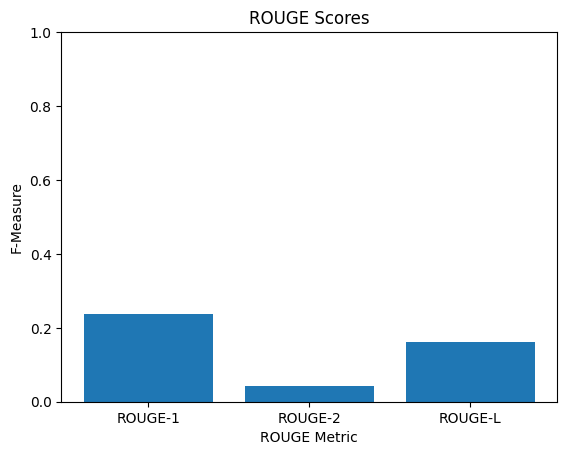

In [55]:
import matplotlib.pyplot as plt

# Extract ROUGE scores (F-measure)
rouge_scores = {
    "ROUGE-1": rouge_result["rouge1"].mid.fmeasure,
    "ROUGE-2": rouge_result["rouge2"].mid.fmeasure,
    "ROUGE-L": rouge_result["rougeL"].mid.fmeasure,
}

# Plot ROUGE scores
plt.bar(rouge_scores.keys(), rouge_scores.values())
plt.title("ROUGE Scores")
plt.ylabel("F-Measure")
plt.xlabel("ROUGE Metric")
plt.ylim(0, 1)
plt.show()


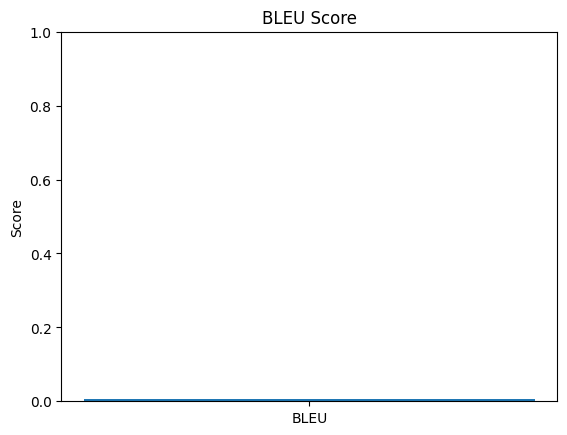

In [56]:
# Plot BLEU score
plt.bar(["BLEU"], [bleu_result["bleu"]])
plt.title("BLEU Score")
plt.ylabel("Score")
plt.ylim(0, 1)
plt.show()


In [64]:
test_text = "Out of this welter of nihilistic reflections, details begin to emerge about Henry’s life in Paris. He lives in the Villa Borghese in the Montparnasse neighborhood with a man named Boris, who’s also a brooding philosophical type. Boris seems to be allowing Henry to stay with him for free, though he employs various excuses to avoid Henry’s repeated requests for breakfast. Henry has no money at all; he has spent his years in Paris as an aspiring writer, but he seems to be letting go of that ambition, though not relinquishing his sense of himself as an “artist” in a vaguer sense."

model.to('cuda')

# Tokenize the input
input_ids = tokenizer(test_text, return_tensors="pt").input_ids.to("cuda")  # Move to GPU if available

# Generate output
outputs = model.generate(
    input_ids,
    max_length=100,         # Allow for longer outputs if needed
    num_beams=10,           # Increase beams for more refined results
    repetition_penalty=2.0, # Penalize repetitive outputs
    length_penalty=2.0,     # Encourage longer outputs
    early_stopping=True
)

# Decode and print the output
decoded_output = tokenizer.decode(outputs[0], skip_special_tokens=True)

print("Generated Output:", decoded_output)

Generated Output: Boris seems to be allowing Henry to stay with him for free, though he employs various excuses to avoid Henry’s repeated requests for breakfast. Henry has no money at all; he has spent his years in Paris as an aspiring writer, but he doesn’t relinquish his sense of himself as an “artist.”
